<a href="https://colab.research.google.com/github/bthorne93/poly-assessment/blob/main/ML_Engineer/poly_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.7 MB/s eta 0:00:00


In [119]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.datasets import MNIST, Flowers102
from torchvision.transforms import Compose, ToTensor, Normalize, Grayscale, Resize, CenterCrop, RandomCrop
import matplotlib.pyplot as plt
import os 
import math
os.environ["WANDB_NOTEBOOK_NAME"] = "/content/poly-assessment.ipynb"

In [4]:
torch.cuda.is_available()

True

In [5]:
import wandb
wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /content/poly-assessment.ipynb.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [42]:
def sobel_filter(img, device="cuda"):
    # Do closest-value padding on images
    img = torch.nn.functional.pad(img, (1, 1, 1, 1), mode="replicate")

    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=device)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=device)
    
    # Reshape filter for convolution
    sobel_x = sobel_x.view((1, 1, 3, 3)) 
    sobel_y = sobel_y.view((1, 1, 3, 3))

    # Apply Sobel filters
    G_x = nn.functional.conv2d(img, sobel_x)
    G_y = nn.functional.conv2d(img, sobel_y)

    # Compute magnitude and direction
    G_mag = torch.sqrt(torch.pow(G_x, 2) + torch.pow(G_y, 2))
    G_dir = torch.atan2(G_y, G_x)

    return G_mag, G_dir
    
# Define custom Sobel dataset class that iterates pairs of input images
# and smoothed images.
class SobelDataset(Dataset):
    def __init__(self, data, device="cuda"):
        self.data = data
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx][0].to(self.device)  # Assumes a single channel
        y, _ = sobel_filter(x, device=self.device)  # Apply Sobel filter to input image
        return x, y

# Define CNN used to learn Sobel Filter
class SobelNet(nn.Module):
    def __init__(self, nfilters=3, nhidden=1, kernel_size=3):
        super(SobelNet, self).__init__()

        self.hidden_layers = nn.ModuleList()
        self.conv_in = nn.Conv2d(1, nfilters, kernel_size, padding=1, padding_mode="replicate")
        for _ in range(nhidden):
            self.hidden_layers.append(nn.Conv2d(nfilters, nfilters, kernel_size, padding=1, padding_mode="replicate"))
        self.conv_out = nn.Conv2d(nfilters, 1, 1)
    
    def forward(self, x):
        x = torch.relu(self.conv_in(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        return self.conv_out(x)

# Load MNIST dataset
def get_MNIST_data(split, device="cuda"):
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    if split=="train":
        mnist = MNIST('data', train=True, download=True, transform=transform)
        trainset, valset = torch.utils.data.random_split(mnist, [30000, 30000])
        return SobelDataset(trainset, device=device), SobelDataset(valset, device=device)

    elif split=="test":
        testset = MNIST('data', train=False, download=True, transform=transform)
        return SobelDataset(testset)
    return 

def get_Flowers102_data(split, device="cuda"):
    "Split should be 'train', 'val' or 'test'."
    transform = Compose([
        Resize(256), 
        CenterCrop(224), 
        Grayscale(num_output_channels=1), 
        ToTensor(),
        Normalize((0.5,), (0.5,))
        ])

    dset = Flowers102('data', split=split, download=True, transform=transform)
    sobel_dset = SobelDataset(dset, device=device)
    return DataLoader(sobel_dset, batch_size=config.batch_size, shuffle=True)

In [80]:
wandb.init(
    project="poly-interview",
    config = {
        "kernel_size": 3,
        "nfilters": 5,
        "nhidden": 5,
        "epochs": 30,
        "batch_size": 64,
        "lr": 0.01,
        "dataset": "Flowers102"
    }
)
wandb.save("/content/poly-assessment.ipynb")
config = wandb.config

# Set device to CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if config.dataset == "MNIST":
    train_loader, val_loader = get_MNIST_data("train", device=device)
if config.dataset == "Flowers102":
    train_loader = get_Flowers102_data("train", device=device)
    val_loader = get_Flowers102_data("val", device=device)

model = SobelNet(nfilters=config.nfilters, nhidden=config.nhidden, kernel_size=config.kernel_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
loss_fn = nn.MSELoss()

train/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train/train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
val/val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,25
train/train_loss,0.45283
val/epoch,25
val/val_loss,0.45057


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


In [81]:
for epoch in range(config.epochs):
    running_train_loss = 0.
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = loss_fn(outputs, labels)
        train_loss.backward()
        optimizer.step()    
        running_train_loss += train_loss.item()

    with torch.no_grad():
        running_val_loss = 0.
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_val_loss += loss.item()

    wandb.log({
        "train/train_loss": running_train_loss / len(train_loader), 
        "train/epoch": epoch,
        "val/val_loss": running_val_loss / len(val_loader),
        "val/epoch": epoch
    })

    print(f"Train Loss: {running_train_loss / len(train_loader):.3f}, Val Loss: {running_val_loss / len(val_loader):3f}")

wandb.finish()

Train Loss: 0.451, Val Loss: 0.435895
Train Loss: 0.361, Val Loss: 0.314614
Train Loss: 0.253, Val Loss: 0.168724
Train Loss: 0.151, Val Loss: 0.126193
Train Loss: 0.104, Val Loss: 0.085798
Train Loss: 0.067, Val Loss: 0.053591
Train Loss: 0.046, Val Loss: 0.041088
Train Loss: 0.036, Val Loss: 0.032245
Train Loss: 0.029, Val Loss: 0.027163
Train Loss: 0.026, Val Loss: 0.026832
Train Loss: 0.029, Val Loss: 0.035991
Train Loss: 0.028, Val Loss: 0.021716
Train Loss: 0.021, Val Loss: 0.020909
Train Loss: 0.019, Val Loss: 0.017550
Train Loss: 0.017, Val Loss: 0.016312
Train Loss: 0.016, Val Loss: 0.015290
Train Loss: 0.015, Val Loss: 0.014324
Train Loss: 0.015, Val Loss: 0.013573
Train Loss: 0.014, Val Loss: 0.013403
Train Loss: 0.013, Val Loss: 0.012785
Train Loss: 0.012, Val Loss: 0.011525
Train Loss: 0.012, Val Loss: 0.010965
Train Loss: 0.012, Val Loss: 0.019165
Train Loss: 0.013, Val Loss: 0.010851
Train Loss: 0.010, Val Loss: 0.010893
Train Loss: 0.010, Val Loss: 0.009151
Train Loss: 

train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/train_loss,█▇▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val/val_loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,29
train/train_loss,0.00892
val/epoch,29
val/val_loss,0.00814


In [83]:
# Get test dataset
if config.dataset == "MNIST":
    test_loader = get_MNIST_data("test", device="cpu")
if config.dataset == "Flowers102":
    test_loader = get_Flowers102_data("test", device="cpu")

# Get test batch of inputs and outputs
_, (test_input, test_true) = next(enumerate(test_loader))

# Get batch of predictions
model = model.to("cpu")
with torch.no_grad():
    test_pred = model(test_input)

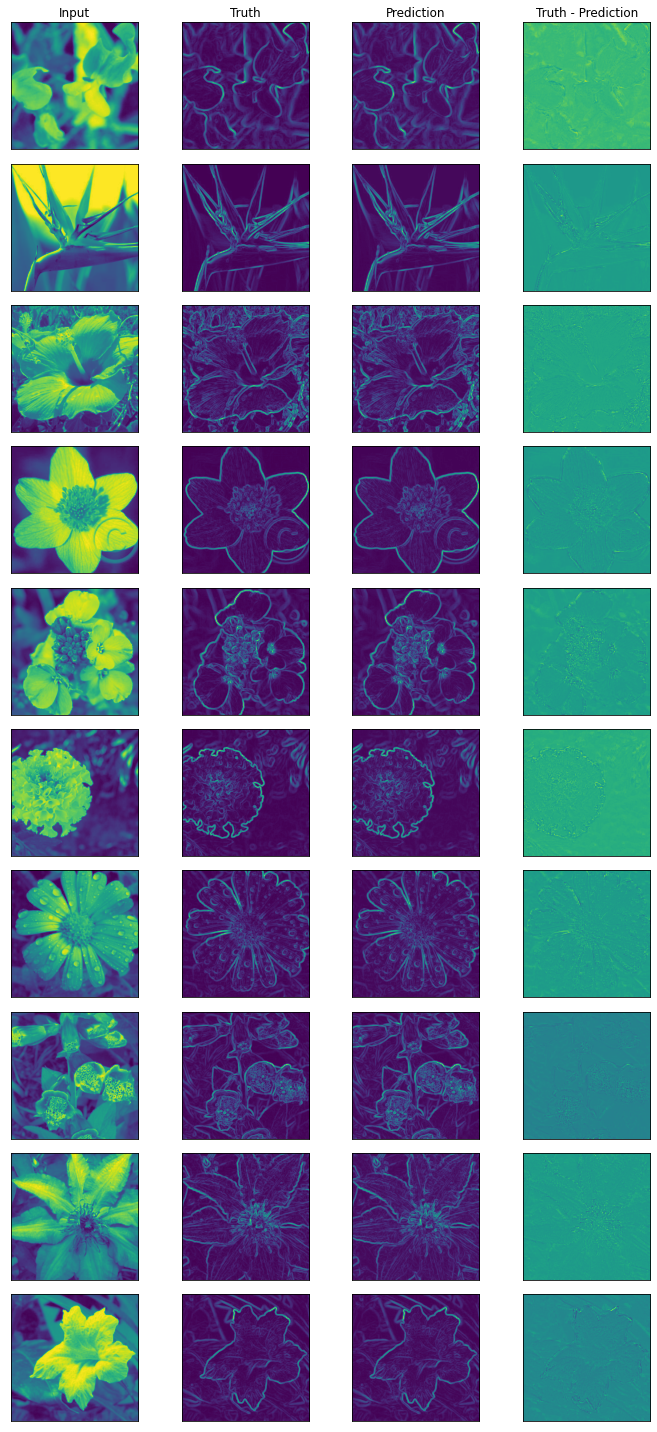

In [84]:
ncols = 4
nrows = 10
vmin, vmax = None, None

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 20))
for row in range(nrows):
    for (col, arr, title) in [
                            (0, test_input, "Input"), 
                            (1, test_true, "Truth"), 
                            (2, test_pred, "Prediction"), 
                            (3, test_true - test_pred, "Truth - Prediction")]:
        if row == 0:
            axes[row, col].set_title(title)
        axes[row, col].imshow(arr.squeeze()[row])
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
fig.tight_layout()

In [116]:
# Get test batch of inputs and outputs
_, (test_input, test_true) = next(enumerate(test_loader))

In [123]:
num_crops = 10
test_input_cropped = []
test_true_cropped = []
test_pred_cropped = []
for (_, test_image) in enumerate(test_input[:num_crops]):
    transform = Compose([
        RandomCrop((torch.randint(10, 220, (1,))[0], torch.randint(10, 220, (1,))[0] ))
    ])
    test_input_cropped.append(transform(test_image))
    test_true_cropped.append(sobel_filter(test_input_cropped[-1], device="cpu")[0])
    with torch.no_grad():
        test_pred_cropped.append(model(test_input_cropped[-1]))

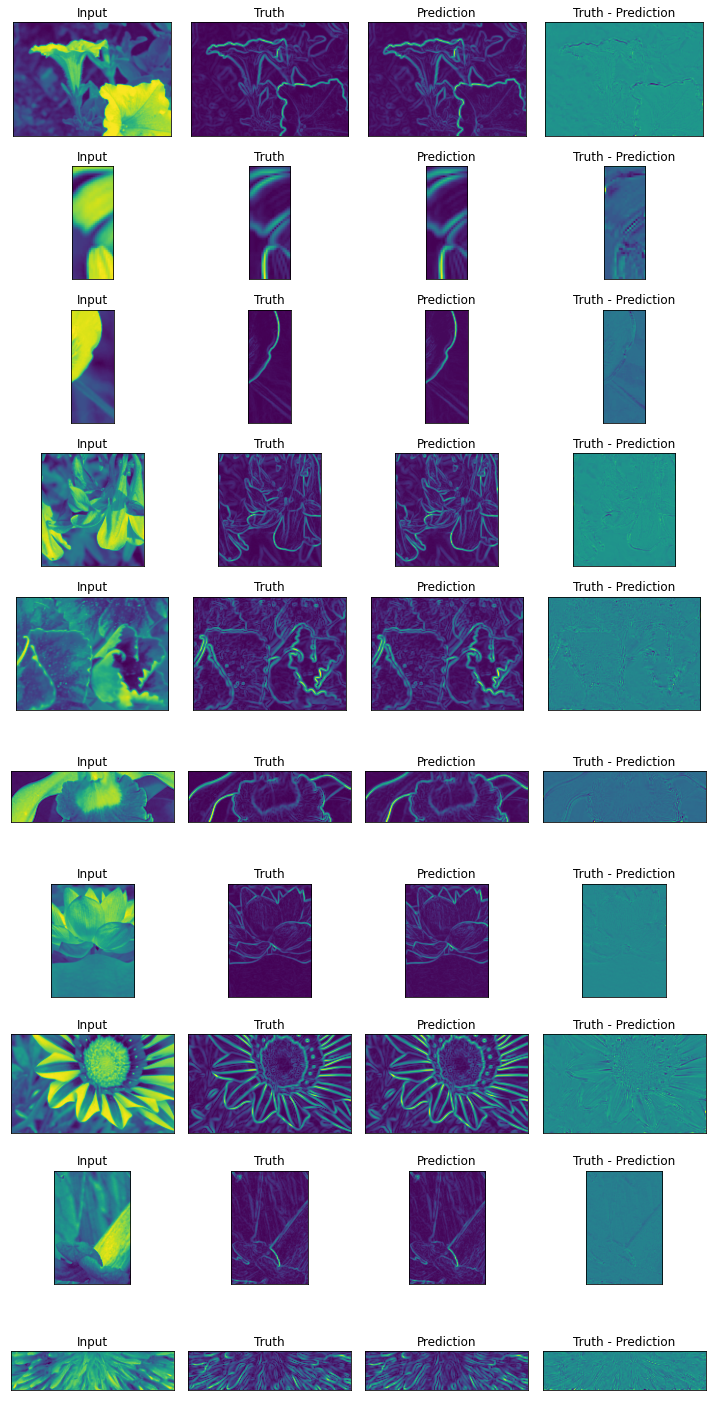

In [124]:
nrows = len(test_true_cropped)
ncols = 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 20))
for row in range(nrows):
    for (col, arr, title) in [
                            (0, test_input_cropped[row], "Input"), 
                            (1, test_true_cropped[row], "Truth"), 
                            (2, test_pred_cropped[row], "Prediction"), 
                            (3, test_pred_cropped[row] - test_true_cropped[row], "Truth - Prediction")]:
        axes[row, col].set_title(title)
        axes[row, col].imshow(arr.squeeze())
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
fig.tight_layout()

In [85]:
import urllib.request
from PIL import Image

In [86]:
urllib.request.urlretrieve("http://www.lenna.org/lena_std.tif", "image.tif")

('image.tif', <http.client.HTTPMessage at 0x7ff1df7497f0>)

In [87]:
img = Image.open("image.tif").convert("L")
transform = Compose(
    [
        Resize(256), 
        CenterCrop(224),
        ToTensor()
    ]
)

test_input = transform(img).unsqueeze(0)
with torch.no_grad():
    test_pred = model(test_input)
test_true = sobel_filter(test_input, device="cpu")[0]


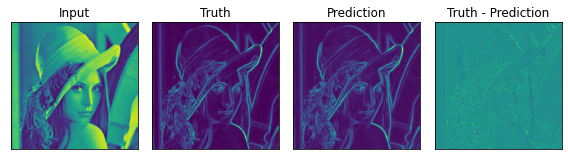

In [88]:
nrows = 1
ncols = 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 3))

for (col, arr, title) in [
                        (0, test_input, "Input"), 
                        (1, test_true, "Truth"), 
                        (2, test_pred, "Prediction"), 
                        (3, test_true - test_pred, "Truth - Prediction")]:
    axes[col].set_title(title)
    axes[col].imshow(arr.squeeze())
    axes[col].set_xticks([])
    axes[col].set_yticks([])
fig.tight_layout()

# Questions

1. What if the image is really large or not of a standard size?



2. What should occur at the edges of the image?
3. Are you using a fully convolutional architecture?
4. Are there optimizations built into your framework of choice (e.g. Pytorch) that can make this fast?
5. What if you wanted to optimize specifically for model size?
6. How do you know when training is complete?
7. What is the benefit of a deeper model in this case? When might there be a benefit for a deeper model (not with a sobel kernel but generally when thinking about image to image transformations)?